# Titanic Prediction

This notebook describes the process of developing a model to predict deaths on the Titanic, based on the input features. 

In [2]:
import numpy as np
import pandas as pd

In [3]:
train_data = pd.read_csv("./data/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preliminary hypotheses
To begin with, let us perform an informal analysis on the features, and whether they are relevant. We exclude the `Survived` feature as this is our prediction target.

The `Variable` column lists the feature we are analyzing. The `Type` describes the feature. The `Segment` categorizes the feature under Human (for human attributes like age or sex) or Passenger (for attributes associated with being a passenger of the Titanic like cabin number). The `Expectation` is our guess on the importance of the feature when predicting the `survival`. The `Conclusion`, which will be added afterwards, is the actual importance as shown by our formal analysis.

| Variable   | Type                                               | Segment   | Expectation                             | Conclusion | Comments                                                     |
| ---------- | -------------------------------------------------- | --------- | --------------------------------------- | ---------- | ------------------------------------------------------------ |
| `pclass`   | The ticket class                                   | Passenger | Medium                                  |            | 1 =  1st, 2 = 2nd, 3 = 3rd <br />The ticket class may have a causal effect on `survival`. It is possible there was some bias in favour of the wealthier passengers in securing lifeboat spots. This may arise from explicit discrimination against lower-class paseengers, or instead, the differences in survival rate may be attributed to, say, lower-class passengers sleeping in cabins on physically lower levels, thus, requiring them to travel further to the lifeboats or preventing them from being notified at the earliest possible moment when the titanic began to sink. <br />The exact effect is unclear and further research is needed, so the expectation is placed at Medium for simplicity. It should be emphasized that a correlation between `pclass` and `survival` **does not definitively prove** that explicit discrimination of lower-class passengers occurred, only that we cannot reject it as a hypothesis based on the observed data. |
| `ticket`   | The ticket number                                  | Passenger | Low                                     |            | This needs more research. If tickets were assigned randomly, then there is likely little to no relationship with `survival`. On the other hand, if tickets were tied to a factor like cabin number, which is tied to wealth, then ticket number may influence survival based on the same explanation for `pclass`<br />From inspection of the data, there appear to be no patterns in how ticket numbers are assigned. In fact, it seems as though different companies with different ticket formats sold tickets to the Titanic, which makes it difficult to compare tickets. For simplicity, we will guess that the ticket numbers are randomly assigned and have no connection to `survival` |
| `fare`     | The passenger fare                                 | Passenger | Medium                                  |            | This feature is probably related to `pclass`. It may be possible to replace the `pclass` with the `fare`. |
| `cabin`    | Cabin number                                       | Passenger | Medium                                  |            | According to this [source](https://www.encyclopedia-titanica.org/cabins.html), this feature is probably related to `pclass`. This feature usually consists of string values consisting of 1 letter, a dash, then up to 2 numbers. It is known that cabin numbers beginning in A were in first-class, but D to F could be second- or third-class. <br />We may consider replacing this feature with `fare`, which is a numerical variable that provides a more reliable indicator of a passenger's socioeconomic status. <br />Alternatively, we can decompose the `cabin` into two features, `cabin-letter` and `cabin-number`, since `cabin` by itself does not duplicate any classes and is ill-suited for one-hot encoding. |
| `embarked` | Port of Embarkation                                | Passenger | Medium                                  |            | C= Cherbourg (France), Q = Queenstown (now Cobh, Ireland), S = Southhampton (England)<br />Further research is needed to justify the hypothesis that `embarked` has a causal relationship to `survival`. One possibility is that Irishmen were discriminated by Englishmen on board the Titanic and were given less priority for lifeboats. More analysis is required to establish any correlation, and it should be emphasized that any correlation found **does not definitively prove** that such discrimination occurred aboard the Titanic, only that we cannot reject it as hypothesis based on the observed data. |
| `Age`      | The age in years                                   | Human     | High                                    |            | It is well-known that women and children were offered lifeboats first. Therefore, age is likely a strong factor in survival. We expect that regardless of gender, lower age increases survival chance. |
| `sex`      | The sex of the passenger                           | Human     | High                                    |            | It is well-known that women and children were offered lifeboats first. Therefore, sex is likely a strong factor in survival. We expect that regardless of age, a woman is more likely to survive than a man. |
| `sibsp`    | The number of siblings / spouses abord the Titanic | Human     | Low/High (depending on `Age` and `Sex`) |            | This factor is likely an important factor in survival. Note that `sibsp`'s effect on `survival` might differ depending on `Age` and `sex`. <br />If `Age` is low or `sex` is female, then `sibsp` will likely be a weak factor influencing `survival`. This is because (1) women and children are prioritized, (2) family units were probably kept together to avoid distress. Therefore, a child or woman would not have to "contest" lifeboat seats with their siblings.<br />On the other hand, for an adult male, since they were not prioritized for lifeboats, then any spouses or siblings (particularly female ones) would contest the adult male, therefore, reducing his likelihood of survival. |
| `parch`    | The number of parents / children abord the Titanic | Human     | Low/High (depending on `Age` and `Sex`) |            | This factor is likely an important factor in survival. Like with `sibsp`, this depends on `Age` and `sex`. For a woman or child, this likely did not affect survival. For an adult male, then a higher `parch` probably implies a lower survival rate. |









In [7]:
# Descriptive statistics for the prediction target
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

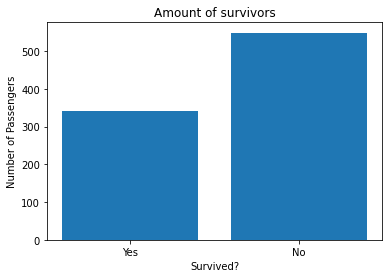


Overall survival rate: 0.384


In [23]:
import matplotlib.pyplot as plt


survived = len(train_data[train_data['Survived'] == 1]) 
total = len(train_data)

fig = plt.figure()
plt.bar(['Yes', 'No'],
         [survived, total - survived])
plt.xlabel('Survived?')
plt.ylabel('Number of Passengers')
plt.title('Amount of survivors')
plt.show()

print("\nOverall survival rate: {0:.3f}".format(survived / total))

In [5]:
women = train_data.loc[train_data.Sex == 'female']['Survived']
rate_women = sum(women) / len(women)

print("% of women who survived: ", rate_women)

% of women who survived:  0.7420382165605095


In [6]:
men = train_data.loc[train_data.Sex == 'male']['Survived']
rate_men = sum(men) / len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [9]:
# Extracting the prediction target
y = train_data.Survived

# Extracting the features
X = train_data.drop(['Survived'], axis=1)

X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# Determine the missing columns
missing_cols = [cname for cname in X.columns if
                X[cname].isnull().any()]
missing_cols

['Age', 'Cabin', 'Embarked']

In [21]:
# Determine the number of missing entries
for cname in missing_cols:
    total = len(X[cname])
    missing = X[cname].isnull().sum()
    perc = missing / total
    print(f"{cname}: {missing} / {total} = {perc:3f}")

Age: 177 / 891 = 0.198653
Cabin: 687 / 891 = 0.771044
Embarked: 2 / 891 = 0.002245


Based on the above results, we should drop the "Cabin" column, as 77% of the values are missing and attempting to impute the missing values based on 23% of the test data might be inaccurate. 



# Exploratory Data Analysis

# Preprocessing

In [ ]:
# Separating categorical and numerical columns

In [ ]:
# Determining how to handle categorical columnms
# - Can missing values be imputed based on `most-frequent` strategy? How many missing values are there? Would we be extrapolating from a small dataset to a larger one?
# - How many classes does the categorical column have? Should we use one-hot strategy?

In [ ]:
# Determining how to handle numerical columns